
# CUNEF MUCD 2022/2023
# Machine Learning

## Analisis of Yelp Dataset

by Gozde Yazganoglu

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json

from os.path import join
from os import path

import pickle

from libpysal import weights

import geopandas as gpd

import contextily as ctx
from contextily.place import Place

import warnings
warnings.filterwarnings('ignore')



from aux_func import process_columns, preview_data, check_missing_feautre

In this notebook we will check restaurants of Philedelphia geographically. We didn't check it on the other notebook since it got very long.

Geographic data of Philedelphia is found from OpenPhilly datas.

In [8]:
# Path we have saved previous processed pickle formated data.


path_processed = '../data/processed/'


In [9]:
with open(Path(path_processed, 'restaurants.pkl'), 'rb') as f:
    # Load the data from the file
    restaurants = pickle.load(f)

In [10]:
preview_data(restaurants)

Dataset has  5854 rows and  96 columns


business_id                name        address          city  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries    935 Race St  Philadelphia   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar    205 Race St  Philadelphia   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP  1224 South St  Philadelphia   
3  QdN72BWoyFypdGJhhI5r7g             Bar One   767 S 9th St  Philadelphia   
4  Mjboz24M9NlBeiOJKLEd_Q    DeSandro on Main   4105 Main St  Philadelphia   

  state postal_code   latitude  longitude  stars  review_count  ...  Monday  \
0    PA       19107  39.955505 -75.155564    4.0            80  ...    True   
1    PA       19106  39.953949 -75.143226    4.0           245  ...   False   
2    PA       19147  39.943223 -75.162568    4.5           205  ...    True   
3    PA       19147  39.939825 -75.157447    4.0            65  ...    True   
4    PA       19127  40.022466 -75.218314    3.0            41  ...   False   

  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  compliment_count  \
0    True       True      True    True      True    True               0.0   
1    True       True      True    True      True    True               0.0   
2    True       True      True    True      True   False               0.0   
3    True       True      True    True      True    True               0.0   
4    True       True      True    True      True    True               0.0   

   elite  friend_count  
0    0.0           0.0  
1    0.0           0.0  
2    0.0           1.0  
3    0.0           0.0  
4    0.0           0.0  

[5 rows x 96 columns]

Without even map we are able to see by locating restaurants according to latitude and longitude. We have a region that has a lot of restaurants.

In [11]:
restaurants = restaurants.set_index('postal_code')

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

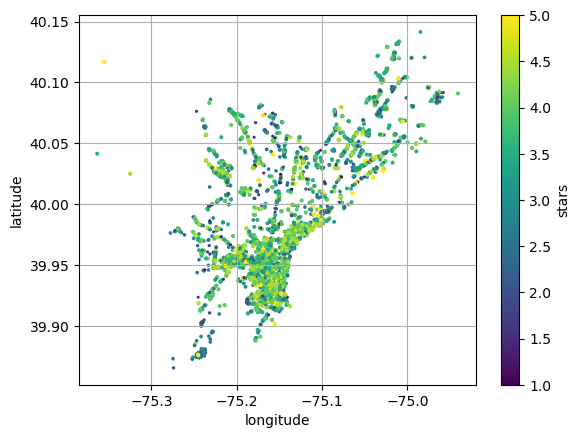

In [12]:
restaurants.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid= True,
                s  = 'stars', colorbar= True, legend = True, c= 'stars',)

In [13]:
#data source : https://www.opendataphilly.org/dataset/zip-codes/resource/659b71f9-522b-4a17-803a-395c12937115

geodata = gpd.read_file("../data/raw/Zipcodes_Poly.geojson")

In [14]:
geodata['postal_code']= geodata['CODE'].map(str)
geodata = geodata.set_index('postal_code')

preview_data(geodata)

Dataset has  48 rows and  6 columns


OBJECTID   CODE  COD   Shape__Area  Shape__Length  \
postal_code                                                      
19120               1  19120   20  9.177970e+07   49921.544063   
19121               2  19121   21  6.959879e+07   39534.887217   
19122               3  19122   22  3.591632e+07   24124.645221   
19123               4  19123   23  3.585175e+07   26421.728982   
19124               5  19124   24  1.448080e+08   63658.770420   

                                                      geometry  
postal_code                                                     
19120        POLYGON ((-75.11107 40.04682, -75.10943 40.045...  
19121        POLYGON ((-75.19227 39.99463, -75.19205 39.994...  
19122        POLYGON ((-75.15406 39.98601, -75.15328 39.985...  
19123        POLYGON ((-75.15190 39.97056, -75.15150 39.970...  
19124        POLYGON ((-75.09660 40.04249, -75.09281 40.039...

In [15]:
#to check if the map is funcioning nice.
geodata.explore()

<AxesSubplot: >

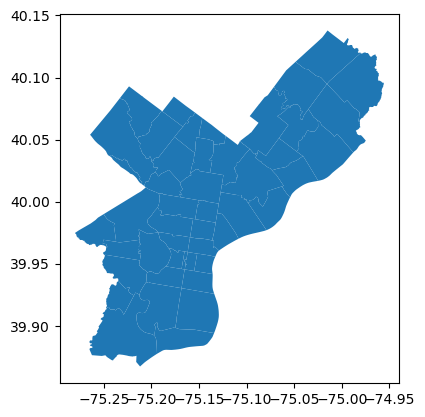

In [16]:
(geodata
    .dissolve(by='CODE')
    .plot()
)

Map in  default is divided into neighbourhoods by Polygons. In order match with our restaurants data we need postal code data this is why we choose in this shape.

In order to restaurant data to join with 

In [17]:
#grouping restaurants according to mean of stars in every region.
rest_mean = restaurants[['stars']].groupby('postal_code').mean()


In [18]:
#grouping restaurants according to number of business in every region and changing variable name. 
rest_count = restaurants[['business_id']].groupby('postal_code').count()
rest_count['bus_count'] = rest_count[['business_id']]
rest_count = rest_count.drop(columns = ['business_id'])

In [19]:
#grouping restaurants according to total of reviews in every region. 
rest_sum = restaurants[['review_count']].groupby('postal_code').sum()


In [20]:
#grouping by Italian food.This variety was the most important in variable selection.
rest_it = restaurants[['Italian']].groupby('postal_code').count()

In [21]:
#merging grouped data, 
rest_group = pd.concat([rest_mean, rest_count, rest_sum, rest_it], axis=1)
preview_data(rest_group)

Dataset has  57 rows and  4 columns


stars  bus_count  review_count  Italian
postal_code                                         
               4.0          1            22        1
19019          4.0          2            26        2
19087          3.5          1            15        1
19092          3.5          1             8        1
19101          3.5          1            13        1

In [22]:
#merging grouped data with geodatata to anlyze and graph
db = (
    gpd.GeoDataFrame(
        geodata.join(rest_group), crs=geodata.crs
    )
    .to_crs(epsg=3857)[
        ['stars','bus_count','review_count','geometry','Italian']
    ].dropna()
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 47 entries, 19120 to 19148
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   stars         47 non-null     float64 
 1   bus_count     47 non-null     float64 
 2   review_count  47 non-null     float64 
 3   geometry      47 non-null     geometry
 4   Italian       47 non-null     float64 
dtypes: float64(4), geometry(1)
memory usage: 3.2+ KB


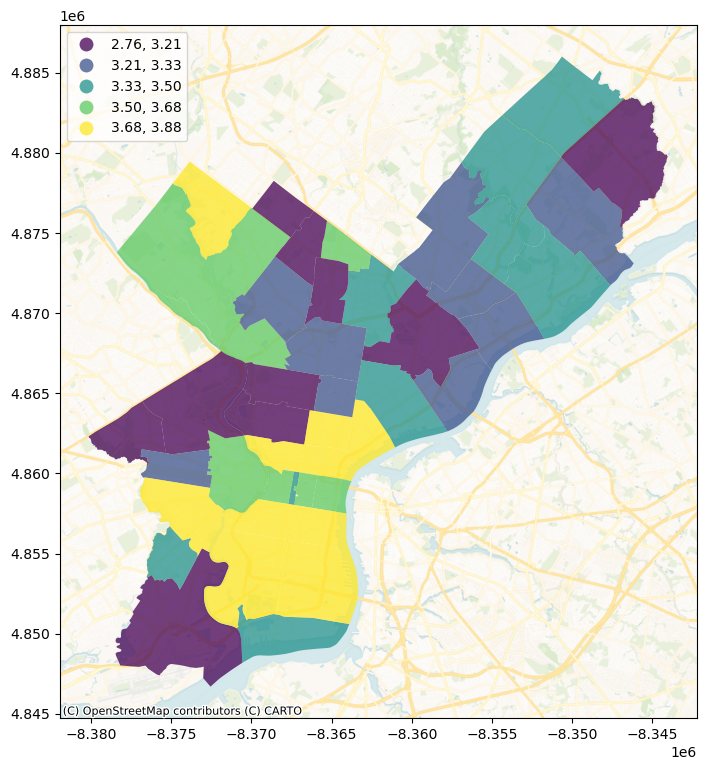

In [23]:

# Set up figure and a single axis

f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="stars", 
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.CartoDB.VoyagerNoLabels,
)


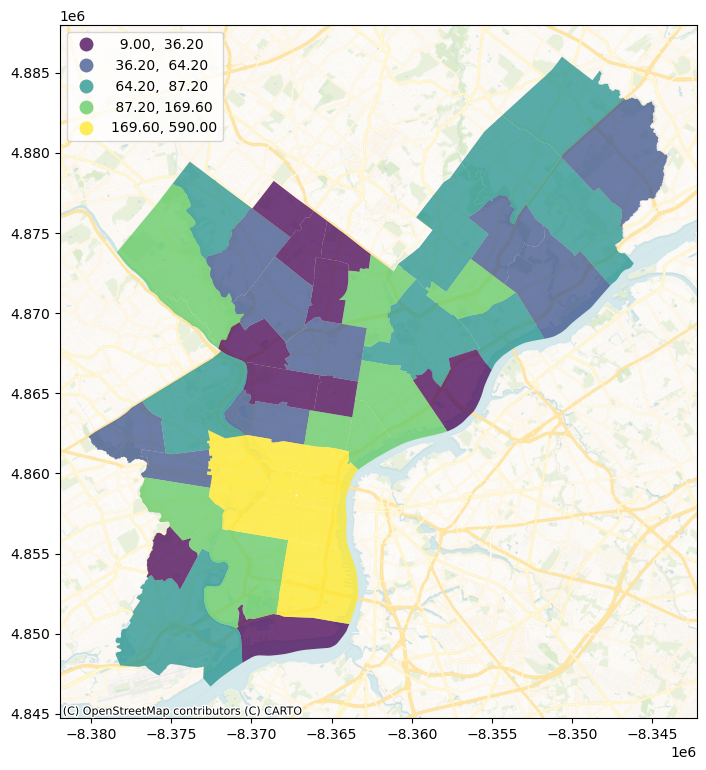

In [24]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="bus_count", 
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.CartoDB.VoyagerNoLabels,
)


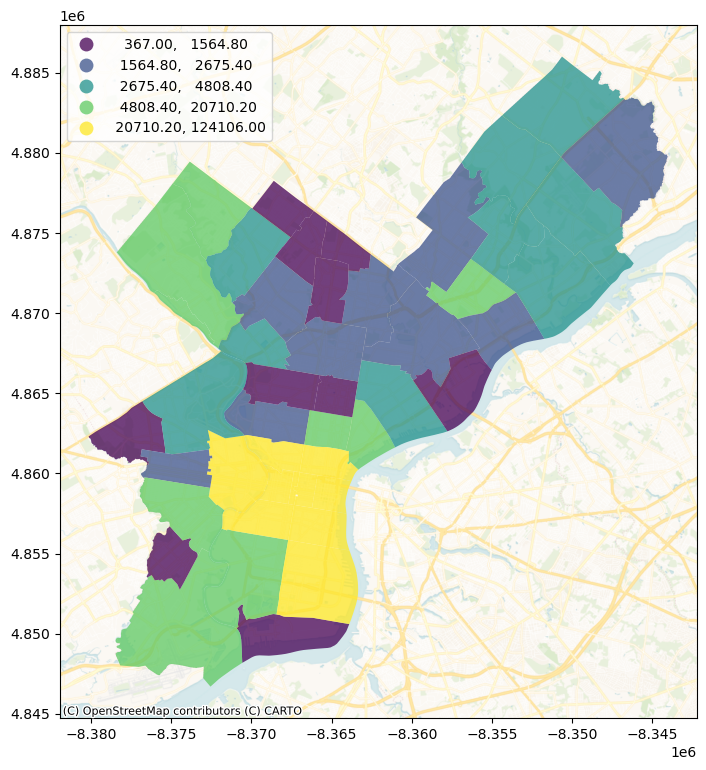

In [25]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="review_count", 
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.CartoDB.VoyagerNoLabels,
)


As seen in the graphs, central region recieve more votes, more high stars and have more restaurants.This means that competition is high in these regions. 

Below we also check as example,how is the situation for Italian food.

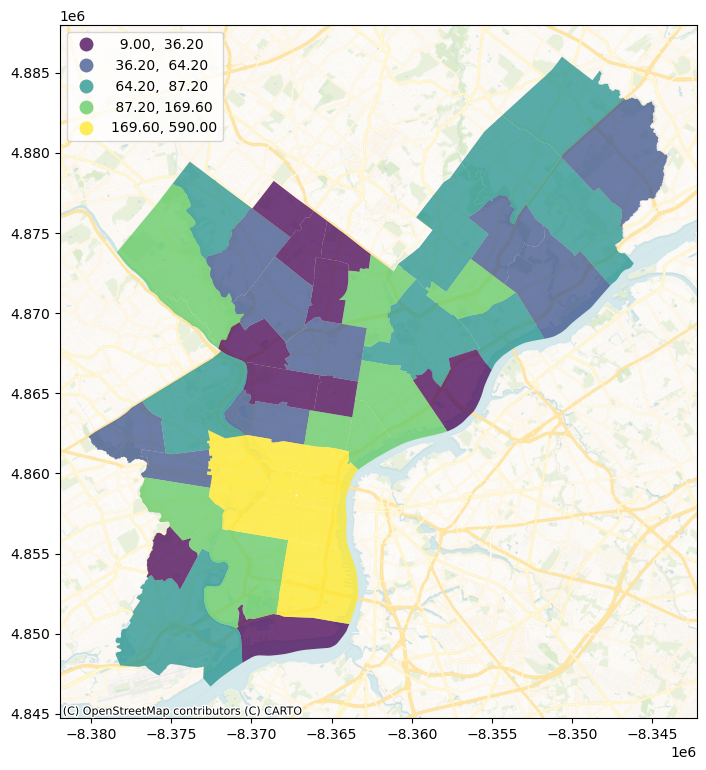

In [26]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Italian", 
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.CartoDB.VoyagerNoLabels,
)


In [27]:
# Generate W from the GeoDataFrame
#w = weights.KNN(db, k=5)
w = weights.distance.KNN.from_dataframe(db, k=10)

# Row-standardization
w.transform = "R"

In [28]:
w.data

array([[-8362332.39088074,  4870878.40967454],
       [-8368961.69419908,  4863338.68219496],
       [-8365228.12618495,  4862682.53643724],
       [-8365265.78436685,  4860662.87676469],
       [-8359390.49617029,  4868516.44941609],
       [-8362826.6646114 ,  4862298.80533296],
       [-8364231.05697007,  4873960.61854837],
       [-8374156.75293503,  4869992.30369697],
       [-8374544.37778508,  4873091.64785539],
       [-8367353.10833611,  4859086.45410266],
       [-8368337.34575911,  4859215.14873212],
       [-8371020.80505154,  4859996.3482342 ],
       [-8365039.71175779,  4858709.26959436],
       [-8366619.42613747,  4858966.08811235],
       [-8357704.24659624,  4875081.19626293],
       [-8367829.59688531,  4849946.84526777],
       [-8349420.44297124,  4875821.19466883],
       [-8353858.22091843,  4879310.57920634],
       [-8350546.21380333,  4882881.8334111 ],
       [-8372552.76641796,  4876436.27955775],
       [-8370344.52590429,  4873625.02025778],
       [-8356

### Motivating Local Spatial Autocorrelation

To better understand the fundamentals of local spatial autocorrelation, the Moran Plot is used as a graphical tool. In this context, it is more intuitive to represent the data in a normalized way, since it will allow us to more easily discern a typology of spatial structure. Let's first calculate the spatial lag of our variable of interest:

In [29]:
db["stars_weighted"] = weights.spatial_lag.lag_spatial(w, db["stars"])#we add weighted values to dataframe

In [30]:
db[["stars","stars_weighted"]].head(10)

stars  stars_weighted
postal_code                          
19120        3.357955        3.252193
19121        3.204918        3.472316
19122        3.815534        3.509850
19123        3.686957        3.605138
19124        3.107143        3.327711
19125        3.881579        3.513663
19126        3.617647        3.234170
19127        3.612150        3.312953
19128        3.521739        3.276418
19102        3.417085        3.644203

In [31]:
#standardization of stars and weighted stars
db["stars_st"] = db["stars"] - db["stars"].mean()
db["stars_w_std"] = db["stars_weighted"] - db["stars_weighted"].mean()

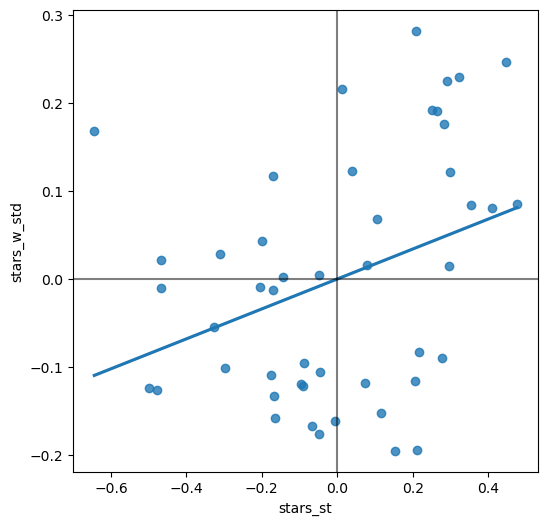

In [32]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="stars_st", y="stars_w_std", data=db, ci=None
);

plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)

According to Moran Plot left upper side of the line represent weighted more than the actual and lower part of the line represents lower weighted compared to actual value.

Graphically we can comment that spatial correlation is low. Because points are not centered around the line. 

### LISA

LISA (Local Indicators of Spatial Association) classification is a method for identifying clusters of high or low values in spatial data. The clusters are identified based on the spatial association between the values in the dataset, and can be either positive (high values tend to be located near other high values) or negative (high values tend to be located near low values).

In [33]:
import esda
# Calculate local Moran's I statistics
lisa = esda.moran.Moran_Local(db["stars"], w)

In [34]:
# Print the p-values for the local Moran's I statistics
print(lisa.p_sim)

[0.026 0.225 0.071 0.004 0.141 0.046 0.017 0.12  0.055 0.002 0.003 0.125
 0.001 0.003 0.065 0.027 0.039 0.123 0.102 0.205 0.221 0.158 0.497 0.302
 0.031 0.004 0.07  0.017 0.023 0.359 0.487 0.034 0.327 0.108 0.034 0.49
 0.3   0.412 0.113 0.078 0.382 0.304 0.126 0.072 0.001 0.001 0.001]


In [35]:
# Print the local Moran's I statistics
print(lisa.Is)

[ 0.09545509 -0.17521972  0.55935572  0.73467634  0.30378365  0.67320211
 -0.47544005 -0.25021645 -0.19624796  0.03602887  0.70676902  0.1255755
  0.83427374  0.7368076   0.24297458  0.07410644  0.28988229  0.05054824
 -0.09148743 -0.23986852 -0.1695931   0.08486777 -0.07921473 -0.21061972
  0.01306303 -1.61010328  0.64548423 -0.34074407  0.56535142 -0.274169
 -0.03696886 -0.31241748  0.04009126  0.11818872  0.12563081 -0.02319202
  0.13459735 -0.04915013  0.120526    0.65461317 -0.01784141  0.14507549
  0.19676464  0.4962586   1.0627337   1.57080264  0.9400885 ]


In [36]:
# Print the quadrant classifications for each observation
print(lisa.q)

[3 2 1 1 3 1 4 4 4 1 1 1 1 1 3 1 3 3 4 4 4 3 2 2 3 2 3 4 1 2 2 2 1 3 3 2 3
 2 3 3 2 1 3 1 1 1 1]


In [37]:
from splot import esda as esdaplot

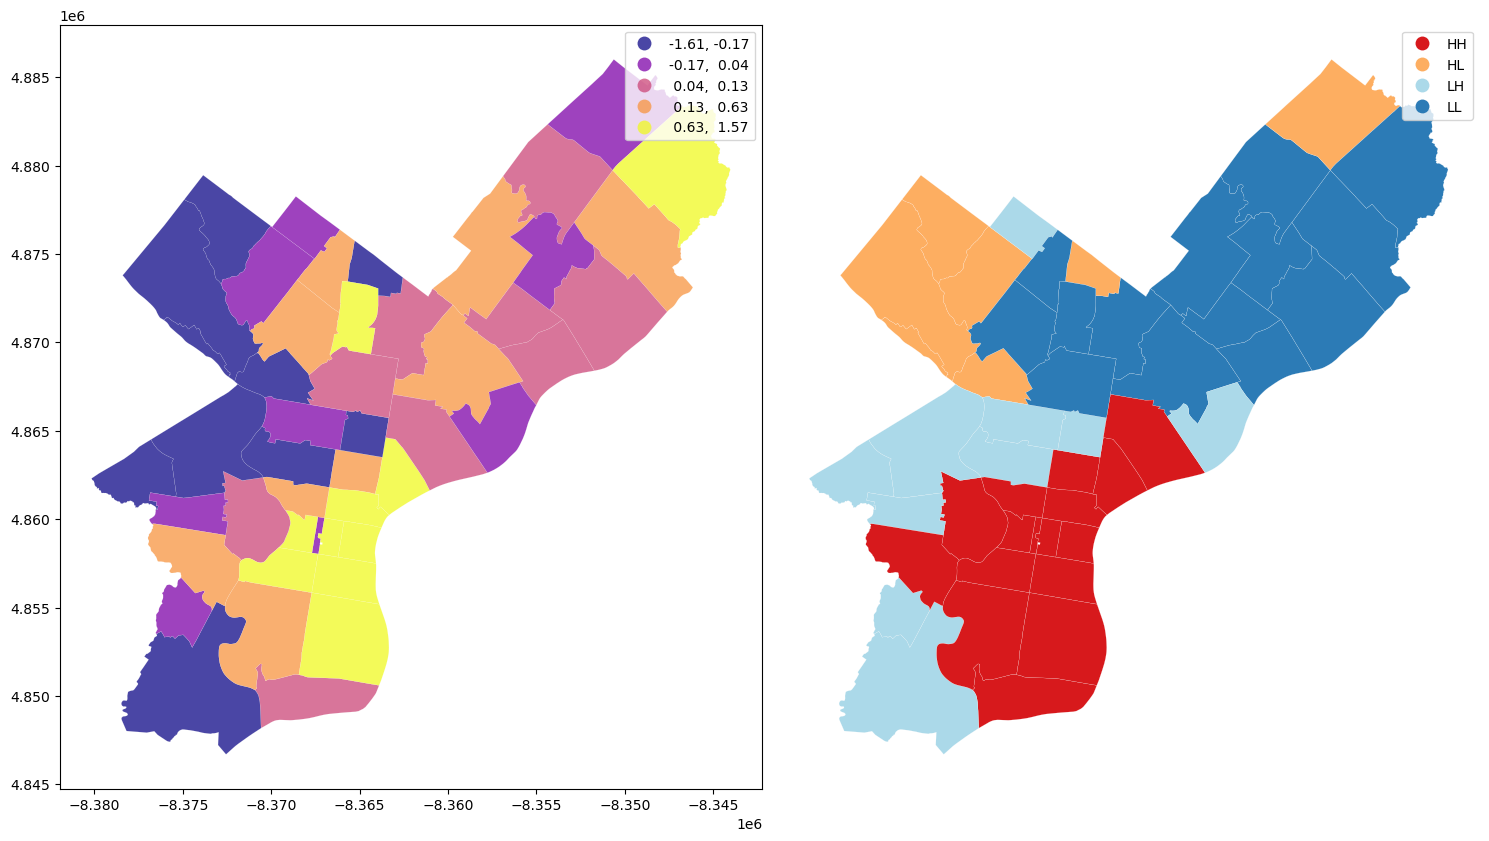

In [38]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axs = axs.flatten()

ax = axs[0]
db.assign(
    Is=lisa.Is
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax
)
ax = axs[1]
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

f.tight_layout()
plt.show()

According to LISA quadrants we found on the map as 

* HH (red) region highly valorated high stars recieving regions.
* LH (light blue) region that has higher weighted stars value than actually it is.
* HL (Orange) are highly valorated but compared spatially low valorated.
* LL (dark blue) are low valorated regions in low valorated areas.

To conclude, the regions we found on the map as recieving more votes and more in high notes are falls in the center area mostly. Although there are higher rated restaurants all around, specifically in the Northwest LH is over_valued compared to region mean. 


Due to below limitations to LISA we should consider this analysis informing for further analisis.

However, LISA classification also has some limitations:

* It does not account for spatial autocorrelation, which can affect the validity of the results.
* It does not provide a precise estimate of the size or boundaries of the identified clusters.
* It does not allow for the incorporation of additional variables or data layers that may influence the spatial patterns in the data.
* It may be sensitive to the choice of the spatial weights matrix, which can affect the results.




In popular areas, opening a restaurant, likely to recieve more popularity in vote numbers and higher valoration. This comes with a high competiton but also high demand. If we assume that people are looking for a place to eat around place they vote, a restaurant with good quality in an area of lowly valorated but with more people can create a difference to the community that are looking for good qualifications. 
